<!--ANNOTATION_BLOCK-->
# Blockade $π–2π–π$ gate comparison

This notebook models neutral-atom Rydberg blockade **π–2π–π** entangling gate, comparing different approaches:

- **Full**: diagonalize ARC’s full pair interaction matrix $m(R)$ to obtain interaction eigenchannels $|\nu\rangle$ with eigenenergies $\Delta_\nu(R)$ and overlaps $c_\nu(R)=\langle rr|\nu\rangle$, and propagate the gate including **all channels**.

- **WS effective blockade shift**: compress the doubly-excited manifold into one effective shift $B(R)$:
$$
\frac{1}{B(R)^2}=\sum_{\nu}\frac{|c_{\nu}(R)|^2}{\Delta_{\nu}(R)^2}.
$$

---

## Units

- ARC returns $m(R)$ in **GHz**.
- Convert $\Delta_\nu$ to Hz: $\Delta_\nu[\mathrm{Hz}]=10^9\,\Delta_\nu[\mathrm{GHz}]$.
- Time evolution uses rad/s: $H_{\mathrm{rad/s}}=2\pi H_{\mathrm{Hz}}$.

Detuning $\delta$:
- single excitation: $+\delta$
- double excitation: $+2\delta$
(entered in Hz, then multiplied by $2\pi$ in the Hamiltonian).

---

## Eigenchannels (theory)

The laser addresses a **bare** doubly-excited state $|rr\rangle$ in the product basis, but interactions mix many pair states.
Diagonalization yields eigenchannels:
$$
m(R)|\nu\rangle=\Delta_{\nu}(R)|\nu\rangle,
$$
and the decomposition
$$
|rr\rangle=\sum_{\nu}c_{\nu}(R)|\nu\rangle,\qquad c_{\nu}(R)=\langle rr|\nu\rangle.
$$
So in **Full**, laser coupling into channels is proportional to $c_{\nu}$.

---

## Fidelity proxy

Extract the 4×4 computational block $M$. Because of leakage, $M$ is non-unitary.
Compute survival $P=\mathrm{Tr}(M^\dagger M)/4$, nearest unitary $U_{\mathrm{eff}}$ by polar decomposition, and compare to ideal CZ up to local $Z\otimes Z$ phases:
$$
F_{\mathrm{avg}}=\frac{\mathrm{Tr}(M^\dagger M)+\left|\mathrm{Tr}\left(U_{\mathrm{CZ}}^\dagger(Z\otimes Z)U_{\mathrm{eff}}\right)\right|^2}{20},
\qquad 1-F_{\mathrm{avg}}\;\text{is the plotted infidelity.}
$$


<!--ANNOTATION_BLOCK-->
## Time evolution with `expm_multiply` (exact segment propagators)

Each gate segment uses a constant Hamiltonian, so:
$$
V\leftarrow e^{-iHt}V
$$
where $V\in\mathbb{C}^{d\times 4}$ batches four initial computational states as columns.
This is exact linear evolution, just computed efficiently for sparse $H$.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.linalg import polar
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import expm_multiply

from arc import Rubidium87, PairStateInteractions

TWOPI = 2*np.pi
def MHz_to_Hz(x): return float(x)*1e6

## 0) Configuration

In [2]:
# Laser-addressed Rydberg state (defines the bare |rr> pair state)
ryd = dict(n=60, l=1, j=1.5, mj=1.5)  # 60P3/2, mj=3/2
theta, phi = 0.0, 0.0

# ARC basis controls
dn, dl = 5, 5
deltaMax_GHz = 30.0
interactionsUpTo = 1

# Sweeps
R_um_grid = np.linspace(1.0, 5.0, 20)
R0_um = 2.0

Omega_2pi_MHz_default = 30.0
Omega_default = TWOPI * MHz_to_Hz(Omega_2pi_MHz_default)  # rad/s

Omega_2pi_MHz_scan = np.linspace(1.0, 100.0, 20)

# WS regularization: avoid 1/Delta^2 blowups extremely close to resonance
Delta_floor_Hz = 1.0e3  # 1 kHz floor

# Completeness plot: show deviation from 1 (recommended)
show_deviation_from_1 = True

## 1) Build ARC pair basis

In [3]:
atom = Rubidium87()
calc = PairStateInteractions(
    atom,
    ryd['n'], ryd['l'], ryd['j'],
    ryd['n'], ryd['l'], ryd['j'],
    ryd['mj'], ryd['mj'],
    interactionsUpTo=interactionsUpTo
)
calc.defineBasis(theta, phi, dn, dl, deltaMax_GHz*1e9, progressOutput=True)

rr_index = int(calc.originalPairStateIndex)
dim_pair = int(len(calc.basisStates))

print("Pair basis dimension (full):", dim_pair)
print("ARC rr_index:", rr_index)


Calculating Hamiltonian matrix...


	matrix (dimension  2789 )

Matrix R3 100.0 % (state 797 of 797)

Pair basis dimension (full): 2789
ARC rr_index: 2228


## 2) Reconstruct ARC interaction matrix m(R) (GHz units)

<!--ANNOTATION_BLOCK-->
## Reconstructing ARC’s pair interaction matrix $m(R)$

ARC stores distance dependence via coefficient matrices (typically starting at $R^{-3}$). Reconstruction implements:

$$
m(R)=m_{\mathrm{diag}}+\frac{m_3}{R^3}+\frac{m_4}{R^4}+\cdots
$$

Notes:
- Result is in **GHz**.
- The relevant dimension for **Full** is the **full matrix shape** you diagonalize, i.e. `m(R).shape`.


In [4]:
def arc_matrix_at_R(calc, R_um):
    # Reconstruct ARC pair interaction matrix at distance R (um) in GHz units.
    R = float(R_um)
    m = calc.matDiagonal.copy()
    rX = (R * 1e-6)**3
    for matRX in calc.matR:
        m = m + matRX / rX
        rX *= (R * 1e-6)
    return m

m0 = arc_matrix_at_R(calc, R_um_grid[0])
print("m(R) shape:", m0.shape)

m(R) shape: (2789, 2789)


## 3) Full spectrum: Delta_nu and c_nu

<!--ANNOTATION_BLOCK-->
## Full diagonalization: eigenchannels and overlaps

Diagonalize $m(R)$:
$$
m(R)|\nu\rangle=\Delta_{\nu}(R)|\nu\rangle.
$$

Compute overlaps with the bare addressed state:
$$
c_{\nu}(R)=\langle rr|\nu\rangle.
$$

Completeness sanity check (full spectrum):
$$
\sum_{\nu}|c_{\nu}(R)|^2\approx 1.
$$

If the spectrum is truncated (e.g. via `eigsh(k<<N)`), this sum can drop below 1 and produce non-physical features in error curves.


In [5]:
def full_spectrum_channels(calc, R_um):
    # Full eigendecomposition of m(R) in the full pair basis.
    # Returns Delta_Hz, c_nu = <rr|nu>, completeness sum |c_nu|^2.
    m = arc_matrix_at_R(calc, R_um)
    M = m.toarray() if hasattr(m, "toarray") else np.asarray(m)
    ev_GHz, vecs = np.linalg.eigh(M)  # vecs columns = eigenvectors
    Delta_Hz = ev_GHz * 1e9
    c_nu = np.conjugate(vecs[rr_index, :])
    comp = float(np.sum(np.abs(c_nu)**2))
    return Delta_Hz, c_nu, comp

## 4) WS effective blockade shift B from channels

<!--ANNOTATION_BLOCK-->
## WS effective blockade shift $B(R)$

WS compresses the full doubly-excited manifold into one effective shift:

$$
\frac{1}{B(R)^2}=\sum_{\nu}\frac{|c_{\nu}(R)|^2}{\Delta_{\nu}(R)^2}.
$$

Interpretation:
- small $|\Delta_{\nu}|$ dominate (because of $1/\Delta^2$)
- near Förster resonances ($\Delta_{\nu}\to 0$) the sum can diverge

If the code uses a floor $|\Delta|\ge \Delta_{\mathrm{floor}}$, treat it as a numerical stabilizer and diagnose with $\Delta_{\min}(R)$, dominant weight $w_{\max}(R)$, and leakage.


In [6]:
def ws_B_from_channels(Delta_Hz, c_nu, Delta_floor_Hz):
    # 1/B^2 = sum |c|^2 / Delta_eff^2 with Delta_eff floored to avoid divergences.
    Delta = np.asarray(Delta_Hz, float)
    c2 = np.abs(c_nu)**2
    Delta_eff = np.sign(Delta) * np.maximum(np.abs(Delta), float(Delta_floor_Hz))
    invB2 = np.sum(c2 / (Delta_eff**2))
    if invB2 <= 0:
        return np.inf
    return float(1.0 / np.sqrt(invB2))

In [7]:
def ws_B_dominant_from_channels(Delta_Hz, c_nu, Delta_floor_Hz):
    """Single-channel (dominant eigenchannel) WS diagnostic.

    Choose ν* = argmax |cν|^2 and keep only that term in
        1/B^2 = Σ |cν|^2 / Δν^2.

    With optional flooring |Δ|≥Δ_floor to avoid divergences, the single-term result is
        B_dom = |Δν*| / |cν*|.

    Returns: (B_dom_Hz, nu_star, w_star, Delta_star_Hz, c_star)
    """
    Delta = np.asarray(Delta_Hz, float)
    c = np.asarray(c_nu, complex)
    w = np.abs(c)**2
    nu_star = int(np.argmax(w))
    Delta_star = float(Delta[nu_star])
    c_star = complex(c[nu_star])
    # floor Δ like in WS(all)
    Delta_eff = np.sign(Delta_star) * max(abs(Delta_star), float(Delta_floor_Hz))
    cabs = abs(c_star)
    if cabs < 1e-15:
        return np.inf, nu_star, float(w[nu_star]), float(Delta_eff), c_star
    B_dom = abs(Delta_eff) / cabs
    return float(B_dom), nu_star, float(w[nu_star]), float(Delta_eff), c_star


## 5) Dynamics: Full-channel hybrid Hamiltonian

<!--ANNOTATION_BLOCK-->
## Hybrid Hamiltonian for π–2π–π propagation

Basis contains:
- computational: $|00\rangle,|01\rangle,|10\rangle,|11\rangle$
- singly excited: $|r0\rangle,|r1\rangle,|0r\rangle,|1r\rangle$
- doubly excited: WS effective state *or* channel basis $|\nu\rangle$

Laser coupling into channels uses:
$$
|rr\rangle=\sum_{\nu}c_{\nu}|\nu\rangle
$$
so couplings scale with $c_{\nu}$ in Full.


In [8]:
# Hybrid basis:
# 0|00>,1|01>,2|10>,3|11>,4|r0>,5|r1>,6|0r>,7|1r>, 8..|nu>

def build_H_full_sparse(Omega_c, Omega_t, Delta_Hz, c_nu, delta_Hz):
    Delta_Hz = np.asarray(Delta_Hz, float)
    c_nu = np.asarray(c_nu, complex)
    N = len(Delta_Hz)
    dim = 8 + N

    diag = np.zeros(dim, dtype=float)
    d = TWOPI * float(delta_Hz)  # rad/s

    # +delta on single Rydberg states
    for idx in (4,5,6,7):
        diag[idx] += d

    # channel energies: 2pi (Delta + 2 delta)
    diag[8:] = TWOPI * (Delta_Hz + 2.0*float(delta_Hz))

    H = diags(diag, 0, format="csr", dtype=complex)

    rows, cols, data = [], [], []
    def add_sym(i, j, v):
        rows.extend([i,j]); cols.extend([j,i]); data.extend([v, np.conjugate(v)])

    if Omega_c != 0:
        oc = complex(Omega_c/2)
        add_sym(2,4,oc)
        add_sym(3,5,oc)
        for nu in range(N):
            add_sym(8+nu, 7, oc*c_nu[nu])

    if Omega_t != 0:
        ot = complex(Omega_t/2)
        add_sym(1,6,ot)
        add_sym(3,7,ot)
        for nu in range(N):
            add_sym(8+nu, 5, ot*c_nu[nu])

    if data:
        H = H + csr_matrix((data,(rows,cols)), shape=(dim,dim), dtype=complex)

    return H

def evolve_pi_2pi_pi_full(Delta_Hz, c_nu, Omega, delta_Hz):
    # Apply pi-2pi-pi using expm_multiply. Propagate 4 computational basis vectors.
    Omega = float(Omega)
    t_pi = np.pi / Omega
    t_2pi = 2*np.pi / Omega
    T_total = 2*t_pi + t_2pi

    dim = 8 + len(Delta_Hz)
    V = np.zeros((dim,4), dtype=complex)
    V[0,0]=1; V[1,1]=1; V[2,2]=1; V[3,3]=1

    H1 = build_H_full_sparse(Omega, 0.0, Delta_Hz, c_nu, delta_Hz)
    V = expm_multiply((-1j)*H1*t_pi, V)

    H2 = build_H_full_sparse(0.0, Omega, Delta_Hz, c_nu, delta_Hz)
    V = expm_multiply((-1j)*H2*t_2pi, V)

    H3 = build_H_full_sparse(Omega, 0.0, Delta_Hz, c_nu, delta_Hz)
    V = expm_multiply((-1j)*H3*t_pi, V)

    return V[:4,:], T_total

## 6) Dynamics: WS reduced model (single shifted |rr>)

In [9]:
# Reduced basis: 0..7 as before, plus 8=|rr>

def build_H_ws_sparse(Omega_c, Omega_t, B_Hz, delta_Hz):
    dim = 9
    diag = np.zeros(dim, dtype=float)
    d = TWOPI * float(delta_Hz)

    for idx in (4,5,6,7):
        diag[idx] += d

    diag[8] = TWOPI * (float(B_Hz) + 2.0*float(delta_Hz))
    H = diags(diag, 0, format="csr", dtype=complex)

    rows, cols, data = [], [], []
    def add_sym(i, j, v):
        rows.extend([i,j]); cols.extend([j,i]); data.extend([v, np.conjugate(v)])

    if Omega_c != 0:
        oc = complex(Omega_c/2)
        add_sym(2,4,oc)
        add_sym(3,5,oc)
        add_sym(7,8,oc)  # |1r><->|rr|

    if Omega_t != 0:
        ot = complex(Omega_t/2)
        add_sym(1,6,ot)
        add_sym(3,7,ot)
        add_sym(5,8,ot)  # |r1><->|rr|

    if data:
        H = H + csr_matrix((data,(rows,cols)), shape=(dim,dim), dtype=complex)

    return H

def evolve_pi_2pi_pi_ws(B_Hz, Omega, delta_Hz):
    Omega = float(Omega)
    t_pi = np.pi / Omega
    t_2pi = 2*np.pi / Omega
    T_total = 2*t_pi + t_2pi

    dim = 9
    V = np.zeros((dim,4), dtype=complex)
    V[0,0]=1; V[1,1]=1; V[2,2]=1; V[3,3]=1

    H1 = build_H_ws_sparse(Omega, 0.0, B_Hz, delta_Hz)
    V = expm_multiply((-1j)*H1*t_pi, V)

    H2 = build_H_ws_sparse(0.0, Omega, B_Hz, delta_Hz)
    V = expm_multiply((-1j)*H2*t_2pi, V)

    H3 = build_H_ws_sparse(Omega, 0.0, B_Hz, delta_Hz)
    V = expm_multiply((-1j)*H3*t_pi, V)

    return V[:4,:], T_total

## 7) Fidelity metrics (leakage-aware, best local-Z alignment)

In [10]:
def ideal_CZ():
    U = np.eye(4, dtype=complex)
    U[3,3] = -1
    return U

def survival_avg(M):
    M = np.asarray(M, complex)
    return float(np.trace(M.conj().T @ M).real / 4.0)

def best_local_Z_overlap(M_unitary, U_target):
    def phase_matrix(a, b):
        return np.diag([1.0, np.exp(1j*b), np.exp(1j*a), np.exp(1j*(a+b))])

    def cost(x):
        a, b = x
        Z = phase_matrix(a, b)
        return -abs(np.trace(U_target.conj().T @ (Z @ M_unitary)))**2

    res = minimize(cost, x0=[0.0, 0.0], method="Nelder-Mead")
    return float(abs(np.trace(U_target.conj().T @ (phase_matrix(*res.x) @ M_unitary)))**2)

def robust_metrics_from_Ucomp(U_comp):
    M = np.asarray(U_comp, complex)
    surv = survival_avg(M)
    leak = 1.0 - surv

    U_eff, _ = polar(M)
    overlap = best_local_Z_overlap(U_eff, ideal_CZ())

    F_cond = overlap / 16.0
    TrMM = float(np.trace(M.conj().T @ M).real)
    F_avg = (TrMM + overlap) / 20.0

    return dict(survival=surv, leakage=leak, F_cond=F_cond, F_avg=F_avg)

## 8) Sweep 1: Infidelity vs distance

In [11]:
rows = []
for R in R_um_grid:
    Delta_Hz, c_nu, comp = full_spectrum_channels(calc, float(R))

    U_full, T = evolve_pi_2pi_pi_full(Delta_Hz, c_nu, Omega_default, delta_Hz=0.0)
    met_full = robust_metrics_from_Ucomp(U_full)

    B_Hz = ws_B_from_channels(Delta_Hz, c_nu, Delta_floor_Hz)
    U_ws, _ = evolve_pi_2pi_pi_ws(B_Hz, Omega_default, delta_Hz=0.0)
    met_ws = robust_metrics_from_Ucomp(U_ws)

    B_dom, nu_star, w_star, Delta_star, c_star = ws_B_dominant_from_channels(Delta_Hz, c_nu, Delta_floor_Hz)
    U_dom, _ = evolve_pi_2pi_pi_ws(B_dom, Omega_default, delta_Hz=0.0)
    met_dom = robust_metrics_from_Ucomp(U_dom)

    rows.append(dict(
        R_um=float(R),
        dim_pair=int(len(Delta_Hz)),
        completeness=float(comp),
        B_Hz=float(B_Hz),
        B_dom_Hz=float(B_dom),
        nu_star=int(nu_star),
        w_star=float(w_star),
        Delta_star_Hz=float(Delta_star),
        T_ns=float(T*1e9),
        inf_avg_full=1.0-met_full["F_avg"],
        inf_avg_ws=1.0-met_ws["F_avg"],
        inf_avg_dom=1.0-met_dom["F_avg"],
        inf_cond_full=1.0-met_full["F_cond"],
        inf_cond_ws=1.0-met_ws["F_cond"],
        inf_cond_dom=1.0-met_dom["F_cond"],
        leak_full=float(met_full["leakage"]),
        leak_ws=float(met_ws["leakage"]),
        leak_dom=float(met_dom["leakage"]),
    ))

df_R = pd.DataFrame(rows).sort_values("R_um").reset_index(drop=True)
df_R

,R_um,dim_pair,completeness,B_Hz,B_dom_Hz,nu_star,w_star,Delta_star_Hz,T_ns,inf_avg_full,inf_avg_ws,inf_avg_dom,inf_cond_full,inf_cond_ws,inf_cond_dom,leak_full,leak_ws,leak_dom
0,1.000000,2789,1.0,8.789060e+08,5.112864e+10,864,0.061709,-1.270101e+10,66.666667,0.800006,0.000183,5.377066e-08,0.999999,0.000178,5.389784e-08,3.494819e-05,2.023382e-04,5.326196e-08
1,1.210526,2789,1.0,5.937015e+08,1.192457e+10,1480,0.130648,4.310171e+09,66.666667,0.800046,0.000357,1.096933e-06,0.999975,0.000399,9.762661e-07,3.295041e-04,1.913732e-04,1.579601e-06
2,1.421053,2789,1.0,1.492484e+09,2.130987e+09,1384,0.558348,1.592331e+09,66.666667,0.000014,0.000060,2.457624e-05,0.000005,0.000063,3.052650e-05,5.085291e-05,4.747239e-05,7.751959e-07
3,1.631579,2789,1.0,6.873072e+08,7.362464e+08,1306,0.756221,6.402469e+08,66.666667,0.000233,0.000240,2.854397e-04,0.000197,0.000295,2.570706e-04,3.765636e-04,2.133427e-05,3.989159e-04
4,1.842105,2789,1.0,2.921847e+08,2.923430e+08,1272,0.918053,2.801086e+08,66.666667,0.001600,0.001529,1.518646e-03,0.001429,0.001668,1.665355e-03,2.286546e-03,9.742383e-04,9.318116e-04
5,2.052632,2789,1.0,1.410665e+08,1.410714e+08,1286,0.962351,1.383903e+08,66.666667,0.006893,0.006489,6.487266e-03,0.006978,0.007236,7.235186e-03,6.552354e-03,3.500874e-03,3.495583e-03
6,2.263158,2789,1.0,7.544018e+07,7.544044e+07,1308,0.980672,7.470782e+07,66.666667,0.024516,0.024483,2.448226e-02,0.024558,0.025177,2.517678e-02,2.434410e-02,2.170515e-02,2.170420e-02
7,2.473684,2789,1.0,4.331681e+07,4.331682e+07,1318,0.989194,4.308214e+07,66.666667,0.064544,0.064547,6.454702e-02,0.070348,0.070959,7.095880e-02,4.132517e-02,3.890003e-02,3.889988e-02
8,2.684211,2789,1.0,2.622730e+07,2.622730e+07,1318,0.993563,2.614275e+07,66.666667,0.092827,0.093888,9.388826e-02,0.090380,0.091284,9.128413e-02,1.026115e-01,1.043048e-01,1.043048e-01
9,2.894737,2789,1.0,1.656036e+07,1.656036e+07,1318,0.995976,1.652701e+07,66.666667,0.133232,0.133533,1.335328e-01,0.157863,0.157970,1.579703e-01,3.470922e-02,3.578307e-02,3.578307e-02


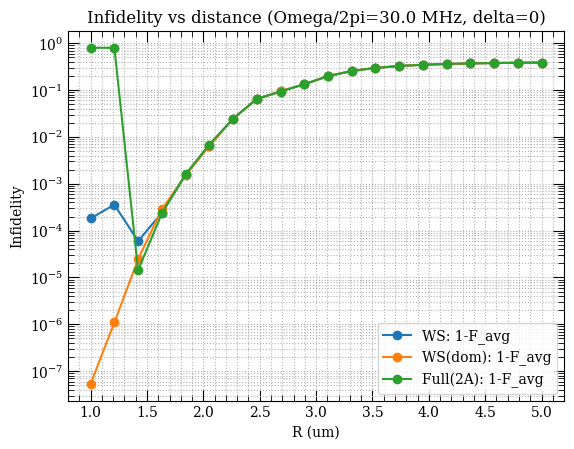

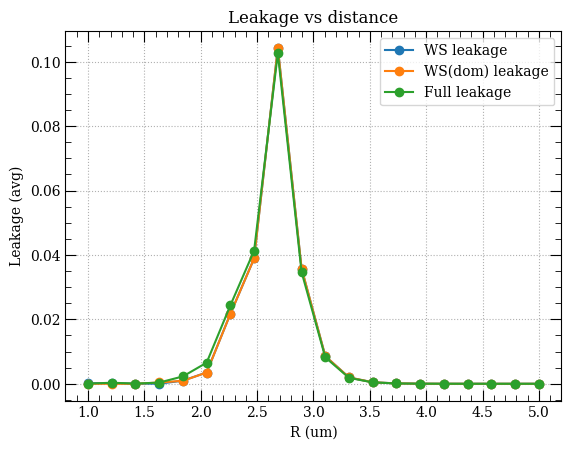

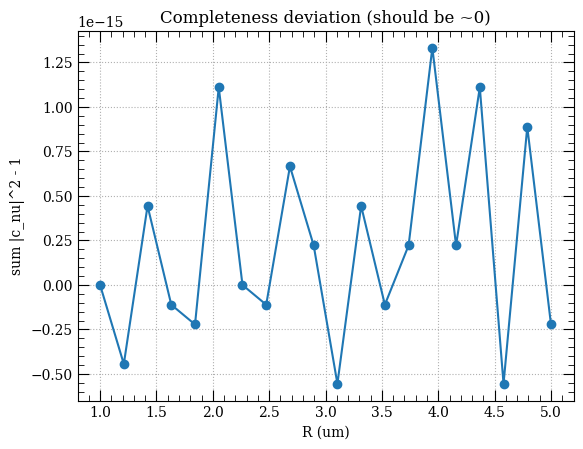

In [12]:
plt.figure()
plt.semilogy(df_R["R_um"], df_R["inf_avg_ws"], "o-", label="WS: 1-F_avg")
plt.semilogy(df_R["R_um"], df_R["inf_avg_dom"], "o-", label="WS(dom): 1-F_avg")
plt.semilogy(df_R["R_um"], df_R["inf_avg_full"], "o-", label="Full(2A): 1-F_avg")
plt.xlabel("R (um)")
plt.ylabel("Infidelity")
plt.title(f"Infidelity vs distance (Omega/2pi={Omega_2pi_MHz_default:.1f} MHz, delta=0)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

plt.figure()
plt.plot(df_R["R_um"], df_R["leak_ws"], "o-", label="WS leakage")
plt.plot(df_R["R_um"], df_R["leak_dom"], "o-", label="WS(dom) leakage")
plt.plot(df_R["R_um"], df_R["leak_full"], "o-", label="Full leakage")
plt.xlabel("R (um)")
plt.ylabel("Leakage (avg)")
plt.title("Leakage vs distance")
plt.grid(True, ls=":")
plt.legend()
plt.show()

plt.figure()
if show_deviation_from_1:
    plt.plot(df_R["R_um"], df_R["completeness"] - 1.0, "o-")
    plt.ylabel("sum |c_nu|^2 - 1")
    plt.title("Completeness deviation (should be ~0)")
else:
    plt.plot(df_R["R_um"], df_R["completeness"], "o-")
    plt.ylabel("sum |c_nu|^2")
    plt.title("Completeness (should be ~1)")
plt.xlabel("R (um)")
plt.grid(True, ls=":")
plt.show()

## 9) Sweep 2: At R=2 um, infidelity vs Omega (and gate time)

In [13]:

Delta0_Hz, c0, comp0 = full_spectrum_channels(calc, float(R0_um))
B0_Hz = ws_B_from_channels(Delta0_Hz, c0, Delta_floor_Hz)
B0_dom_Hz, nu0_star, w0_star, Delta0_star_Hz, c0_star = ws_B_dominant_from_channels(Delta0_Hz, c0, Delta_floor_Hz)

rows = []
for Om_2pi in Omega_2pi_MHz_scan:
    Omega = TWOPI * MHz_to_Hz(Om_2pi)

    U_full, T = evolve_pi_2pi_pi_full(Delta0_Hz, c0, Omega, delta_Hz=0.0)
    met_full = robust_metrics_from_Ucomp(U_full)

    U_ws, _ = evolve_pi_2pi_pi_ws(B0_Hz, Omega, delta_Hz=0.0)
    met_ws = robust_metrics_from_Ucomp(U_ws)

    U_dom, _ = evolve_pi_2pi_pi_ws(B0_dom_Hz, Omega, delta_Hz=0.0)
    met_dom = robust_metrics_from_Ucomp(U_dom)

    rows.append(dict(
        Omega_2pi_MHz=float(Om_2pi),
        T_ns=float(T*1e9),
        T_times_Omega=float(T*Omega),
        inf_avg_full=1.0-met_full["F_avg"],
        inf_avg_ws=1.0-met_ws["F_avg"],
        inf_avg_dom=1.0-met_dom["F_avg"],
    ))

df_Om = pd.DataFrame(rows)
print("R0 completeness:", comp0)
print("B0/2pi (MHz):", B0_Hz/1e6/TWOPI)
df_Om.head()

R0 completeness: 1.0
B0/2pi (MHz): 26.633949302168375


,Omega_2pi_MHz,T_ns,T_times_Omega,inf_avg_full,inf_avg_ws,inf_avg_dom
0,1.000000,2000.000000,12.566371,0.000006,0.000006,0.000006
1,6.210526,322.033898,12.566371,0.000214,0.000171,0.000171
2,11.421053,175.115207,12.566371,0.000720,0.000746,0.000745
3,16.631579,120.253165,12.566371,0.001244,0.001245,0.001245
4,21.842105,91.566265,12.566371,0.002824,0.002648,0.002647


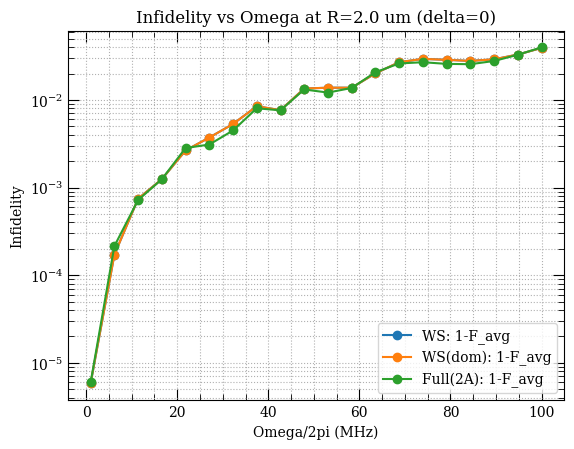

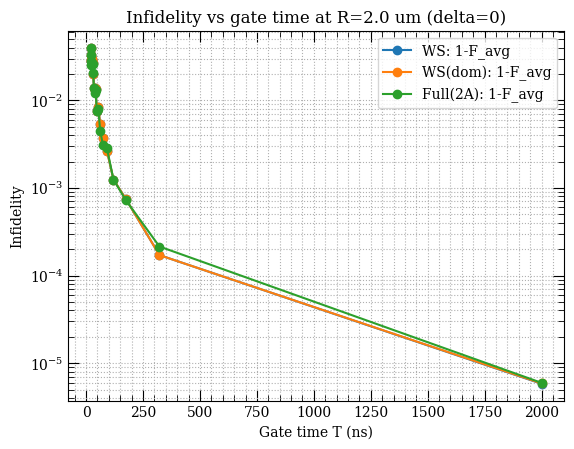

Check T*Omega ~ 4*pi = 12.566370614359172
Observed T*Omega min/max: 12.56637061435917 12.566370614359174


In [17]:
plt.figure()
plt.semilogy(df_Om["Omega_2pi_MHz"], df_Om["inf_avg_ws"], "o-", label="WS: 1-F_avg")
plt.semilogy(df_Om["Omega_2pi_MHz"], df_Om["inf_avg_dom"], "o-", label="WS(dom): 1-F_avg")
plt.semilogy(df_Om["Omega_2pi_MHz"], df_Om["inf_avg_full"], "o-", label="Full(2A): 1-F_avg")
plt.xlabel("Omega/2pi (MHz)")
plt.ylabel("Infidelity")
plt.title(f"Infidelity vs Omega at R={R0_um:.1f} um (delta=0)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(df_Om["T_ns"], df_Om["inf_avg_ws"], "o-", label="WS: 1-F_avg")
plt.semilogy(df_Om["T_ns"], df_Om["inf_avg_dom"], "o-", label="WS(dom): 1-F_avg")
plt.semilogy(df_Om["T_ns"], df_Om["inf_avg_full"], "o-", label="Full(2A): 1-F_avg")
plt.xlabel("Gate time T (ns)")
plt.ylabel("Infidelity")
plt.title(f"Infidelity vs gate time at R={R0_um:.1f} um (delta=0)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

print("Check T*Omega ~ 4*pi =", 4*np.pi)
print("Observed T*Omega min/max:", df_Om["T_times_Omega"].min(), df_Om["T_times_Omega"].max())